In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
df_w = load_data(file_name="df_weekly_685.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="dict_weekly_685.pkl", file_path=WORK_DATA_DIR)

# correlation

In [5]:
# select model features
cols = [
    'vixo',
     'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
    'ff_HML',
     'termspread',
     'pc_ratio',
     'aaii_Bullish',
    'sp_close',
    'sp_close_lag1',
    'sp_close_lag2',
    'sp_close_lag3',
    'sp_agg1',
    # 'goog_sent',
    # 'fears35'
]

In [6]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [7]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["sp_cols"]],
              "sp_close_lead1",
              show_plot=False)

[['vixo', 7, 0.083],
 ['naaim_ind', 8, 0.153],
 ['ff_M_RF', 0, 0.181],
 ['ff_SMB', 9, 0.07],
 ['ff_RMW', 0, 0.07],
 ['ff_CMA', 1, 0.085],
 ['ff_HML', 5, 0.102],
 ['termspread', 1, 0.067],
 ['pc_ratio', 7, 0.081],
 ['aaii_Bullish', 6, 0.088]]

In [8]:
df_ws = shift_var_relative_to_df(df_ws, shift_var=["ff_CMA", 
                                                   "vixo",
                                                   "naaim_ind",
                                                   "ff_HML"
                                                   # "naaim_ind",
                                                   # "aaii_Bullish"
                                                  ], no_lags=[
    1,
    7,
    8,
    5
    # 8,
    # 6
])

# Multicolinerarity

,VIF,corr_sp_close_lead1
ff_M_RF,1.711253,-0.181186
naaim_ind,1.039740,-0.152973
sp_close,1.682413,-0.147267
ff_CMA,1.055356,-0.083382
vixo,1.022153,-0.082647
ff_SMB,1.139950,-0.061756
sp_close_lag2,2.187366,-0.009829
sp_close_lag1,2.286087,0.013489
sp_close_lag3,1.809392,0.018549
termspread,1.043116,0.022298


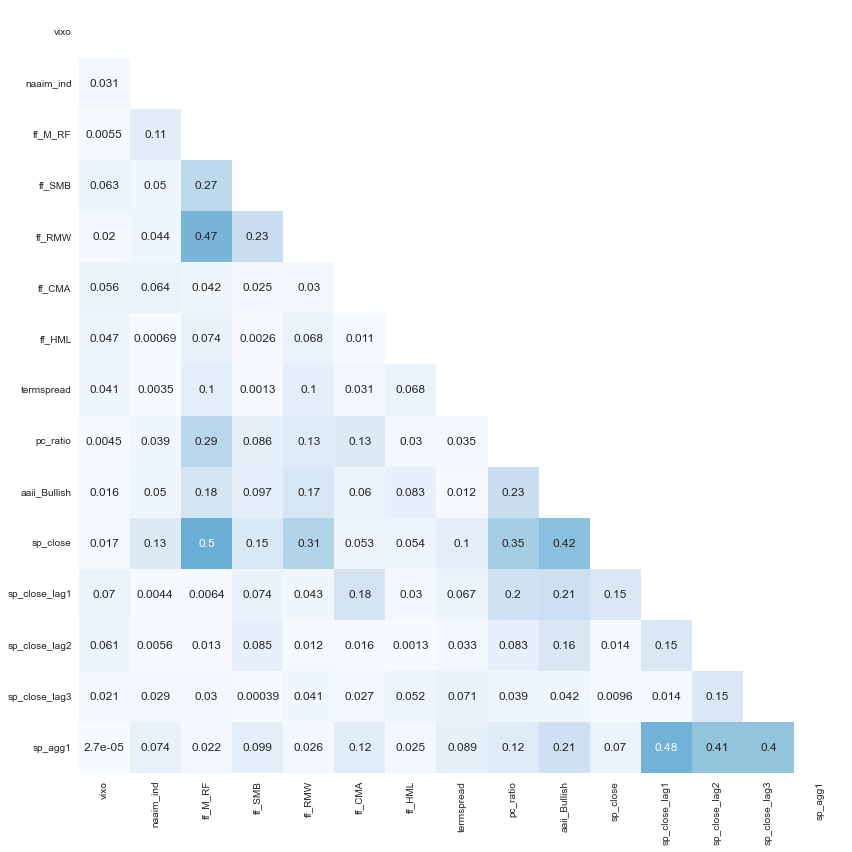

In [9]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             size_factor=.8,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Regression

In [10]:
df_train = df_ws.copy()

In [11]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.2)

In [12]:
model = sm.OLS(y_train, X_train).fit()

In [13]:
model.pvalues < 0.05

vixo              True
naaim_ind         True
ff_M_RF           True
ff_SMB           False
ff_RMW           False
ff_CMA            True
ff_HML            True
termspread       False
pc_ratio         False
aaii_Bullish      True
sp_close          True
sp_close_lag1    False
sp_close_lag2    False
sp_close_lag3    False
sp_agg1          False
intercept        False
dtype: bool

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.793
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           9.30e-09
Time:                        14:48:26   Log-Likelihood:                 1217.9
No. Observations:                 542   AIC:                            -2404.
Df Residuals:                     526   BIC:                            -2335.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo             -0.0212      0.008     -2.655      0.008      -0.037      -0.006
naaim_ind        -0.0096      0.003     -3.228      0.001      -0.015      -0.004
ff_M_RF          -0.0030      0.001     -2.730      0.007      -0.005      -0.001
ff_SMB           -0.0023      0.002     -1.102      0.271      -0.006       0.002
ff_RMW           -0.0007      0.004     -0.207      0.836      -0.008       0.006
ff_CMA           -0.0079      0.004     -2.015      0.044      -0.016      -0.000
ff_HML            0.0038      0.001      2.682      0.008       0.001       0.007
termspread        0.0048      0.009      0.533      0.594      -0.013       0.022
pc_ratio         -0.0037      0.006     -0.585      0.559      -0.016       0.009
aaii_Bullish      0.0262      0.007      3.732      0.000       0.012       0.040
sp_close         -0.1205      0.054     -2.227      0.026      -0.227      -0.014
sp_close_lag1     0.0294      0.063      0.465      0.642      -0.095       0.154
sp_close_lag2     0.0157      0.061      0.258      0.797      -0.104       0.136
sp_close_lag3     0.0081      0.055      0.148      0.883      -0.100       0.116
sp_agg1           0.0197      0.042      0.465      0.642      -0.063       0.103
intercept         0.0012      0.001      1.010      0.313      -0.001       0.004
==============================================================================
Omnibus:                       96.391   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              521.992
Skew:                          -0.649   Prob(JB):                    4.47e-114
Kurtosis:                       7.629   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

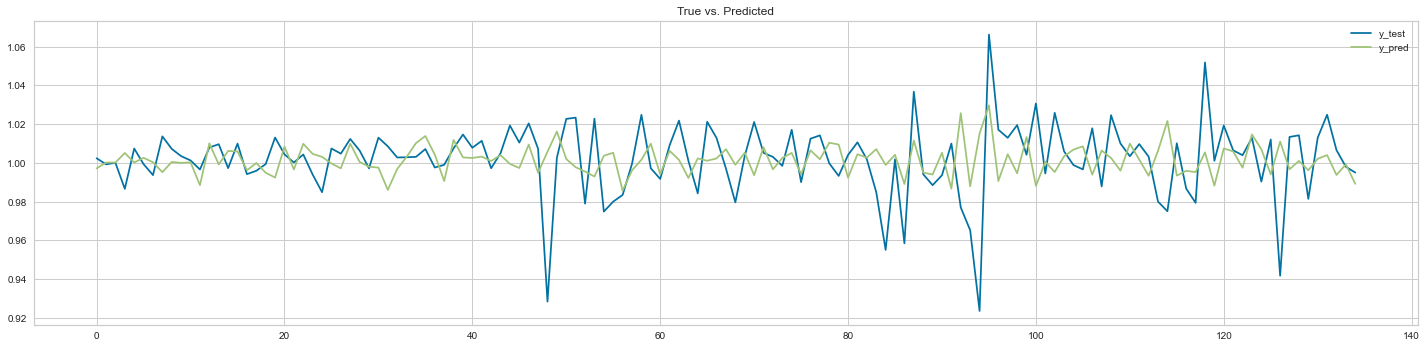

Validation Scores
mean squared error: 0.00040724
mean absolute error: 0.01418093
R2: -0.1687


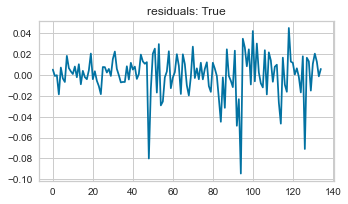

Stationarity Test Results
P-Values: 7.808993366237126e-23
Test-stats: -12.291486292227052
Time series is stationary: True


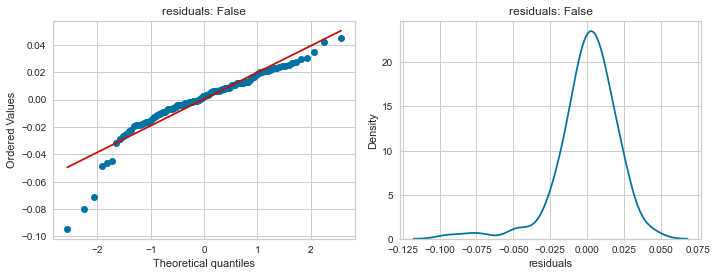

Normality Test Results
P-Values: 6.248976265240861e-13
Test-stats: 56.20237711230406
Series is normally distributed: False


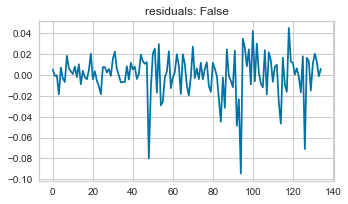

Test for Heteroskedasticity
Test p-value: 0.45951888044828637
Heteroskedasticity is present: False


In [15]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(
    X_train,
    y_train,
    X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

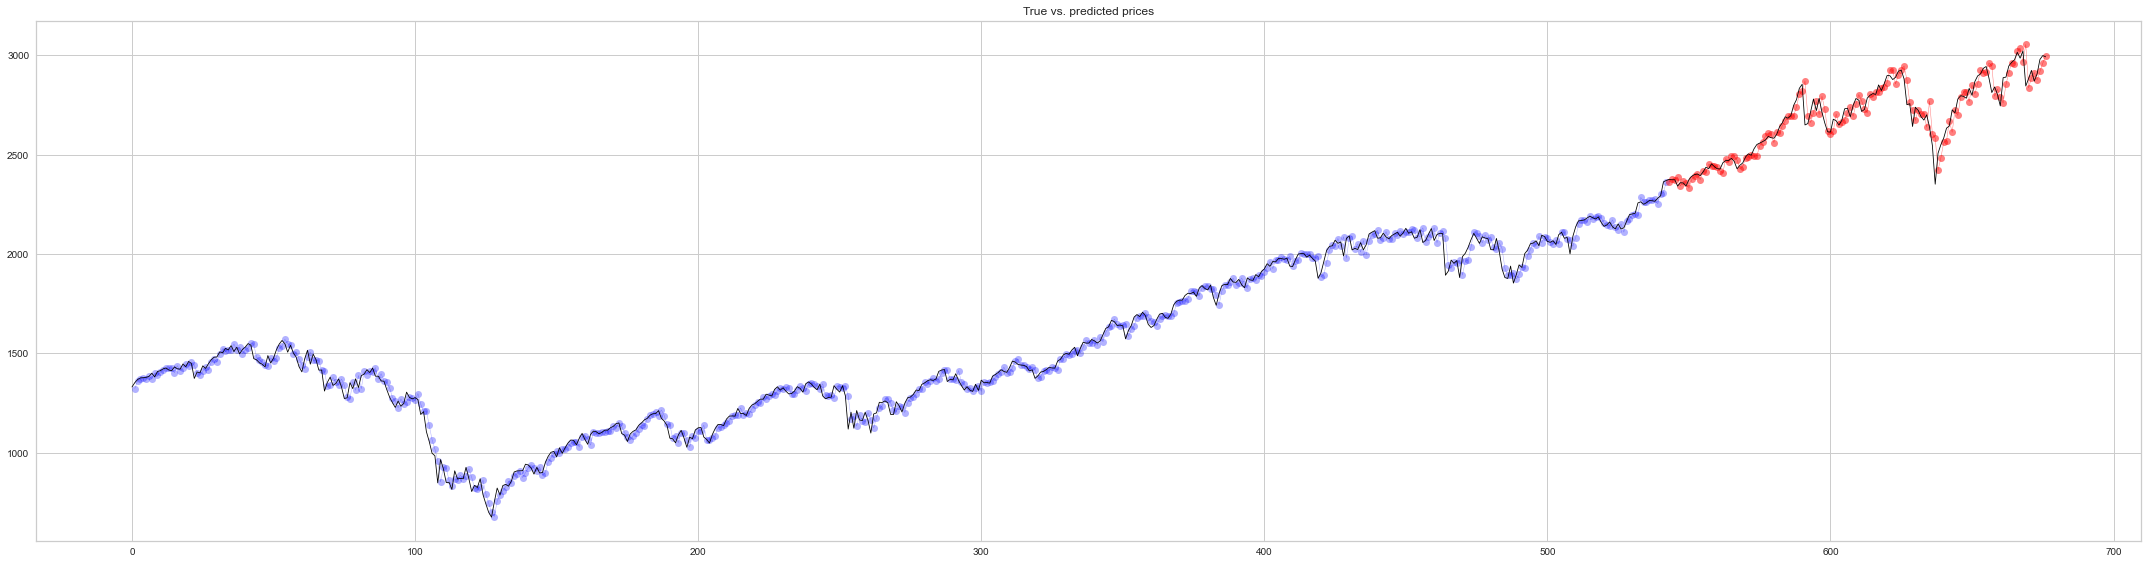

Validation Scores Test Data
mean squared error: 3072.7785851060735
mean absolute error: 38.6838169268295
mean absolute error %: 2.206571071255056


In [16]:
mval.plot_results_on_price_scale(df_w,
                                 df_ws)

# Save model

In [17]:
save_model(df_train, model, mval, data_dict, name="four_features_vixo_splag_splagmul_pcr_ffMRF", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-10_four_features_vixo_splag_splagmul_pcr_ffMRF_model.pkl"? (y/n)


 n
